In [1]:
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os
from contextlib import suppress
import random

from pathlib import Path
from collections import OrderedDict

from ema import ModelEma
from optim_factory import create_optimizer, get_parameter_groups, LayerDecayValueAssigner

import utils
from utils import NativeScalerWithGradNormCount as NativeScaler

from build_dataset import build_dataset
from engine_self_training import train_one_epoch, evaluate

from model import clip_classifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys, os, argparse, yaml

In [3]:
sys.argv = ['-f']

In [4]:
parser = argparse.ArgumentParser('MUST training and evaluation script', add_help=False)
parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--save_ckpt_freq', default=10, type=int)
parser.add_argument('--eval_freq', default=1, type=int) 

# CLIP parameters
parser.add_argument("--template", default='templates.json', type=str)
parser.add_argument("--classname", default='classes.json', type=str)
parser.add_argument('--clip_model', default='ViT-B/16', help='pretrained clip model name') 
parser.add_argument('--image_mean', default=(0.48145466, 0.4578275, 0.40821073)) 
parser.add_argument('--image_std', default=(0.26862954, 0.26130258, 0.27577711)) 
parser.add_argument('--input_size', default=224, type=int, help='images input size') 

# training parameters
parser.add_argument("--train_config", default='train_configs.json', type=str, help='training configurations') 
parser.add_argument('--mask', action='store_true')
parser.set_defaults(mask=True)
parser.add_argument('--distributed',action='store_true')
parser.add_argument('--model_ema_decay', type=float, default=0.9998, help='')
parser.add_argument('--model_ema_force_cpu', action='store_true', default=False, help='')

# Optimizer parameters
parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                    help='Optimizer (default: "adamw"')
parser.add_argument('--opt_eps', default=1e-8, type=float, metavar='EPSILON',
                    help='Optimizer Epsilon (default: 1e-8)')
parser.add_argument('--opt_betas', default=None, type=float, nargs='+', metavar='BETA',
                    help='Optimizer Betas (default: None, use opt default)')
parser.add_argument('--weight_decay', type=float, default=0.05,
                    help='weight decay (default: 0.05)')
parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                    help='learning rate (default: 1e-3)')
parser.add_argument('--layer_decay', type=float, default=0.65)
parser.add_argument('--warmup_lr', type=float, default=1e-6, metavar='LR',
                    help='warmup learning rate (default: 1e-6)')
parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR',
                    help='lower lr bound for cyclic schedulers that hit 0')
parser.add_argument('--warmup_epochs', type=int, default=0, metavar='N',
                    help='epochs to warmup LR, if scheduler supports')
parser.add_argument('--warmup_steps', type=int, default=-1, metavar='N',
                    help='num of steps to warmup LR, will overload warmup_epochs if set > 0')

# Augmentation parameters  
parser.add_argument('--train_crop_min', default=0.3, type=float)
parser.add_argument('--color_jitter', type=float, default=0, metavar='PCT')
parser.add_argument('--aa', type=str, default='rand-m9-mstd0.5-inc1', metavar='NAME',
                    help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m9-mstd0.5-inc1)'),
parser.add_argument('--train_interpolation', type=str, default='bicubic',
                    help='Training interpolation (random, bilinear, bicubic default: "bicubic")')

# Dataset parameters
parser.add_argument('--nb_classes', default=0, type=int, help='number of the classification types')
parser.add_argument('--dataset', default='sun397', type=str, help='dataset name')

parser.add_argument('--output_dir', default='', help='path to save checkpoint and log')
parser.add_argument('--device', default='cuda',
                    help='device to use for training / testing')
parser.add_argument('--seed', default=0, type=int)
parser.add_argument('--resume', default='',
                    help='resume from checkpoint')
parser.add_argument('--auto_resume', action='store_true')
parser.set_defaults(auto_resume=True)

parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                    help='start epoch')
parser.add_argument('--eval', action='store_true',
                    help='Perform evaluation only')
parser.add_argument('--num_workers', default=10, type=int)

# distributed training parameters
parser.add_argument('--world_size', default=1, type=int,
                    help='number of distributed processes')
parser.add_argument('--local_rank', default=-1, type=int)
parser.add_argument('--dist_on_itp', action='store_true')
parser.add_argument('--dist_url', default='env://',
                    help='url used to set up distributed training')
parser.add_argument('--amp', action='store_true')


_StoreTrueAction(option_strings=['--amp'], dest='amp', nargs=0, const=True, default=False, type=None, choices=None, help=None, metavar=None)

In [5]:
from model import clip_classifier
args = parser.parse_args()
model = clip_classifier(args)

missing keys:
['visual.mask_token_embedding', 'visual.ln_patch.weight', 'visual.ln_patch.bias', 'visual.decoder.0.weight', 'visual.decoder.0.bias']
397 classes, 2 templates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:03<00:00, 118.16it/s]


In [87]:
print(model.classnames[85],model.classnames[0])

cathedral outdoor abbey


In [6]:
checkpoint = torch.load('/shared/rsaas/michal5/must/outputs/sun397_512_batch/checkpoint-best.pth')
model.load_state_dict(checkpoint['model'],strict=False)

<All keys matched successfully>

In [7]:
args.nb_classes = len(model.classnames)
dataset_val = build_dataset(is_train=False, args=args)

Transform = 
Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
CenterCrop(size=(224, 224))
ToTensor()
Normalize(mean=tensor([0.4815, 0.4578, 0.4082]), std=tensor([0.2686, 0.2613, 0.2758]))
---------------------------


In [14]:
sample,target = dataset_val.__getitem__(0)


In [15]:
print(sample.size())

torch.Size([3, 224, 224])


In [16]:
from PIL import Image
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [8]:
from ema import ModelEma
model_ema = ModelEma(
        model,
        decay=args.model_ema_decay,
        resume='')

In [9]:
model_ema.ema.eval()

clip_classifier(
  (model): CLIP(
    (visual): VisionTransformer_MIM(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQu

In [10]:
 data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=1,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=False,shuffle=True
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction fire station actual fire station
torch.Size([3, 224, 224])


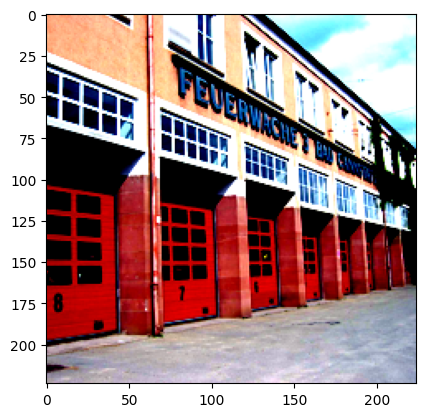

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
#for entry in data_loader_val:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction',model.classnames[predict.cpu().item()],'actual',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: cabin outdoor actual: chalet
torch.Size([3, 224, 224])


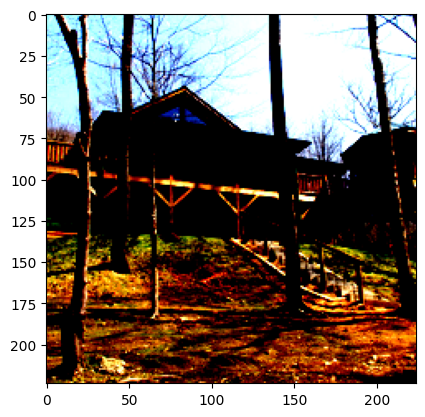

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: oilrig actual: landing deck
torch.Size([3, 224, 224])


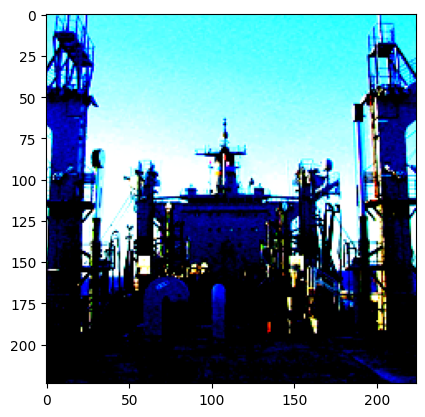

In [24]:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: jail cell actual: locker room
torch.Size([3, 224, 224])


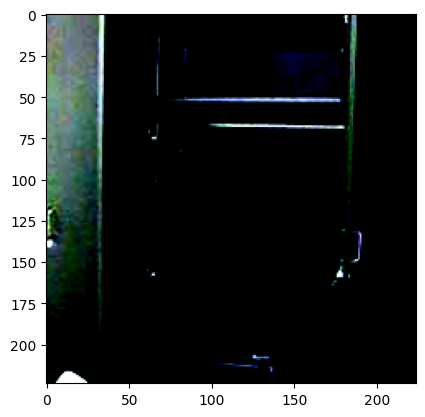

In [29]:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: vegetable garden actual: cottage garden
torch.Size([3, 224, 224])


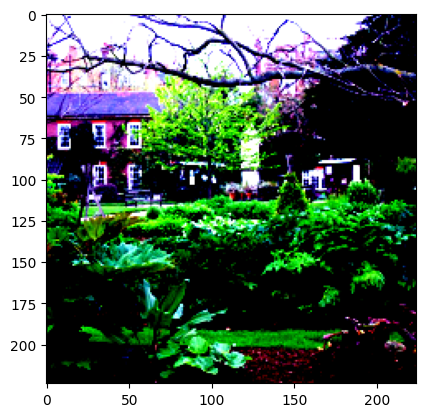

In [30]:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: bedroom actual: bedroom
torch.Size([3, 224, 224])


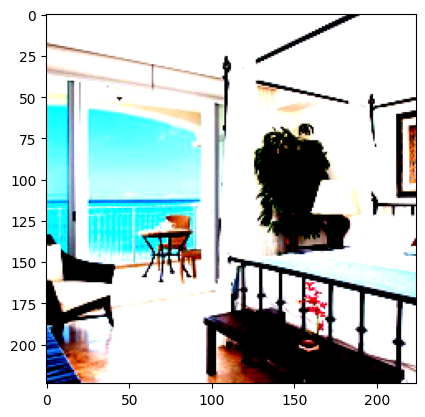

In [32]:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: mountain snowy actual: mountain snowy
torch.Size([3, 224, 224])


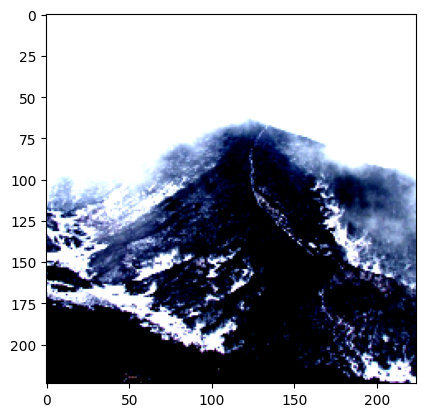

In [34]:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: schoolhouse actual: house
torch.Size([3, 224, 224])


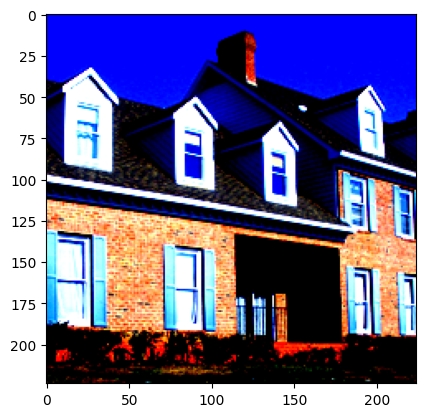

In [35]:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: castle actual: abbey
torch.Size([3, 224, 224])


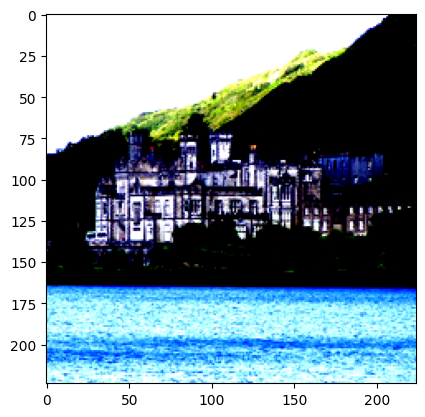

In [39]:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: abbey actual: mansion
torch.Size([3, 224, 224])


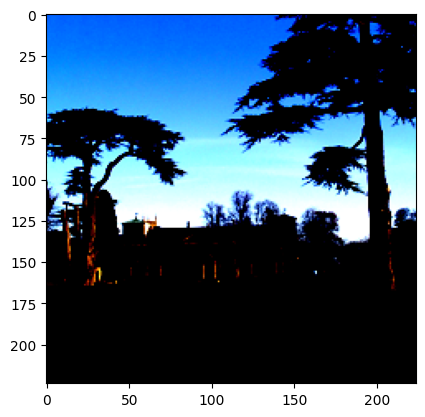

In [43]:
dataiter = iter(data_loader_val)

sample,target = dataiter.next()
sample = sample.to('cuda')
output = model(sample)
_,predict = output.topk(1)
print('prediction:',model.classnames[predict.cpu().item()],'actual:',model.classnames[target.cpu().item()])
sample = sample.squeeze()
print(sample.size())
img = np.transpose(sample.cpu().numpy(), (1, 2, 0))

#     img = F.to_pil_image(sample)
#     img = img[::-1,:,:]
plt.imshow(img)